In [1]:
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
import toolbox as tb
import kaggleData as kD

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import os
import math
import time

from sklearn import cross_validation

Populating the interactive namespace from numpy and matplotlib


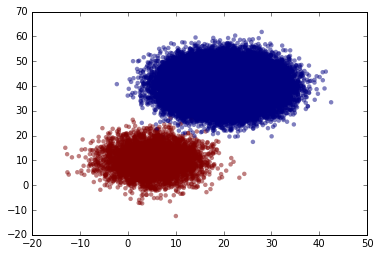

In [2]:
#toydata shall have n vectors with 5 dimensions
n = 100000
#probability for signal-label
s_prob = 0.05
dim = 4
data = tb.createToyData(n,dim,s_prob)
weights = data[:,0]
labels = data[:,1]
x_1 = data[:,2]
x_2 = data[:,3]

%pylab inline
plt.scatter(x_1, x_2, edgecolor="", c=labels, alpha=0.5)

For Comparison, we calculate the best possible AMS    
(case: every signal correctly detected)

In [3]:
tb.calcMaxAMS(weights,labels);

Found 4924 signals.
Weightsums signal: 122.088401872 | background: 0
Maximum AMS possible with this Data: 20.919691541640447


prepare (=normalize) data

In [4]:
X=data[:,2:4]
X /= np.max(np.abs(X),axis=0)

In [5]:
n_train = int(n/10)

train_X,test_X = tb.splitList(X,n_train)
train_labels,test_labels = tb.splitList(labels,n_train)
test_weights = tb.splitList(weights,n_train)[1]

In [6]:
tb.calcMaxAMS(test_weights,test_labels);

Found 4450 signals.
Weightsums signal: 109.92777691 | background: 0
Maximum AMS possible with this Data: 19.391201720198715


classify with knN

In [7]:
neigh = neighbors.KNeighborsClassifier(n_neighbors=5,n_jobs=4)
neigh.fit(train_X,train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=5, p=2,
           weights='uniform')

In [8]:
pred = neigh.predict(test_X)

Populating the interactive namespace from numpy and matplotlib


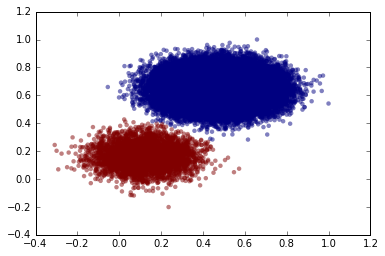

In [9]:
%pylab inline
plt.scatter(test_X[:,0], test_X[:,1], edgecolor="", c=pred, alpha=0.5)

In [ ]:
s,b = tb.calcWeightSums(test_weights,pred,test_labels)
print("AMS:",tb.calcAMS(s,b))

In [21]:
def kNN(train_data,train_labels,test_data,timed=False,n_jobs = 4,k = 20,p=2,thresh = 0.8):

    #setup
    neigh = neighbors.KNeighborsClassifier()
    neigh.set_params(algorithm = 'auto',
                     leaf_size = 30,
                     metric = 'minkowski',
                     metric_params = None,
                     n_jobs = n_jobs,
                     n_neighbors = k,
                     #p=1 <=> manhattan-distance
                     #p=2 <=> euclidian
                     p = p,
                     weights = 'distance')
    
    #cross-validation
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(
        train_data, train_labels, test_size=0.4, random_state=0)
    neigh.fit(X_train,y_train)
    cv_score = neigh.score(X_test, y_test)
    
    #performance-testing
    time_train = 0.
    time_test = 0.
    if timed:
        start = time.time()   
        
    neigh.fit(train_data,train_labels)
    
    if timed:
        end = time.time()
        time_train = end - start
        start = time.time()
    
    #predict test_data, use threshold
    soft_pred = neigh.predict_proba(test_data)
    hard_pred = tb.customThreshold(soft_pred[:,1],thresh)
    
    if timed:
        end = time.time()
        time_test = end - start
    
    #
    del neigh
    return hard_pred,soft_pred,cv_score,time_train,time_test

# Times for 
# 20.928184986114502 sec - k=20
# 264.2239580154419 sec - k=5

Let's use Kaggle-Data:

In [11]:
csv_data,csv_header = kD.csvToArray()
#11.244635105133057 sec
train_data,train_header,test_data,test_header=kD.getOriginalKaggleSets(csv_data,csv_header)
#6.534369945526123 sec
sol_data,sol_header = kD.getSolutionKey(csv_data,csv_header)
#2.880207061767578 sec
test_events = kD._extractFeature("EventId",test_data,csv_header).astype(float)
#15.12389588356018 sec

In [12]:
#cut, if given, EventId and Weight, preserve Label as new array, pls
train_all = train_data[:,1:-2].astype(float)
train_labels = kD.translateLabels(train_data[:,-1],["Label"]).astype(float)
train_weights = train_data[:,-2].astype(float)
test_all = test_data[:,1:].astype(float)
header_all = test_header[1:]

#4.617290019989014 sec

In [13]:
header_1 = ["DER_mass_MMC",
            "DER_mass_transverse_met_lep",
            "DER_mass_vis",
            "DER_met_phi_centrality",
            "DER_pt_ratio_lep_tau",
            "PRI_tau_pt",
            "DER_pt_h"]
train_1 = kD._extractFeatures(header_1,train_data,train_header).astype(float)
test_1 = kD._extractFeatures(header_1,test_data,test_header).astype(float)

In [14]:
header_6 = np.copy(header_1).tolist()
header_6.append("PRI_jet_num")
train_6 = kD._extractFeatures(header_6,train_data,train_header).astype(float)
test_6 = kD._extractFeatures(header_6,test_data,test_header).astype(float)

In [15]:
import sklearn.preprocessing as prep

In [16]:
train_6n = prep.normalize(train_6, norm='l2')
test_6n = prep.normalize(test_6, norm='l2')

In [49]:
for k in np.arange(1,302,2):
    s_predn = kNN(train_6n,train_labels,test_6n,timed=False,n_jobs = 4,k = k,p=1)[1]

    predn,maxAMS,bestThresh = tb.bestThreshold(s_predn[:,1],sol_data)

    b_ams,v_ams = tb.calcSetAMS(predn,sol_data)
    print("k=", k, "Public AMS:",b_ams[0],"|| Private AMS:",v_ams[0],"|| Threshold:",bestThresh)

k= 1 Public AMS: 1.5453562563052605 || Private AMS: 1.537947395242949 || Threshold: 0.888888888889
k= 3 Public AMS: 1.7506079498191016 || Private AMS: 1.7671311165360784 || Threshold: 0.555555555556
k= 5 Public AMS: 1.8550451678575262 || Private AMS: 1.8756060313874319 || Threshold: 0.555555555556
k= 7 Public AMS: 1.9110612753470921 || Private AMS: 1.9315042796009336 || Threshold: 0.444444444444
k= 9 Public AMS: 1.9689933444344563 || Private AMS: 1.9823853557044815 || Threshold: 0.444444444444
k= 11 Public AMS: 2.000157753143695 || Private AMS: 2.013574987949119 || Threshold: 0.444444444444
k= 13 Public AMS: 2.0228622298694945 || Private AMS: 2.0624515192864994 || Threshold: 0.555555555556
k= 15 Public AMS: 2.0559363620707902 || Private AMS: 2.0853206439010266 || Threshold: 0.555555555556
k= 17 Public AMS: 2.0731471656834555 || Private AMS: 2.1005034700956573 || Threshold: 0.555555555556
k= 19 Public AMS: 2.084930971590652 || Private AMS: 2.1183978449563514 || Threshold: 0.555555555556

In [47]:
tb.calcSetAMS(predn,sol_data)

((2.1633947513297738, 357.04952197234087, 27109.87983277284),
 (2.2108178147483817, 361.14821974092445, 26554.755509792813))

In [25]:
tb.calcSetAMS(pred,sol_data)

((2.941792679901681, 249.16115540885605, 7081.0147700303851),
 (2.969235812113241, 250.24197764452407, 7009.8957807312854))

In [ ]:
#tb.createSolutionFile(test_eventList,pred[:,1],0.8,"F:\BA_git\Data\Solutions\solution_kNN_all.csv")

In [40]:
tb.bestThreshold(s_predn[:,1],sol_data)

(array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 2.1633947513297738,
 0.55555555555555558)

In [ ]:
featList = ["DER_mass_MMC",
            "DER_mass_transverse_met_lep",
            "DER_mass_vis",
            "DER_met_phi_centrality",
            "DER_pt_ratio_lep_tau",
            "PRI_tau_pt",
            "DER_pt_h"]
b_X,v_X,train_X,test_X = getBVDataSets(featList,header,b_data,v_data,test_data,train_data)

In [ ]:
#public score
tb.calcMaxAMS(b_weights,b_labels);

In [ ]:
#private score
tb.calcMaxAMS(v_weights,v_labels);

In [ ]:
neigh = neighbors.KNeighborsClassifier(n_neighbors=20,n_jobs=4)
neigh.fit(train_X,train_labels)
pred_b = neigh.predict(b_X)
pred_v = neigh.predict(v_X)
pred_test = neigh.predict(test_X)

In [ ]:
s,b = tb.calcWeightSums(b_weights,pred_b,b_labels)
print("public AMS:",tb.calcAMS(s,b))

In [ ]:
s,b = tb.calcWeightSums(v_weights,pred_v,v_labels)
print("private AMS:",tb.calcAMS(s,b))

In [ ]:
def getBestN(n_range,train_X,test_X,test_weights,test_labels,train_labels):
    maxAMS = 0
    bestN = 0
    neigh = neighbors.KNeighborsClassifier(weights='distance',n_jobs=4)
    for n in n_range:
        neigh.set_params(n_neighbors=n)
        neigh.fit(train_X,train_labels)
        predProb = neigh.predict_proba(test_X)
        pred = tb.customThreshold(predProb[:,1],0.8)
        s,b = tb.calcWeightSums(test_weights,pred,test_labels)
        ams = tb.calcAMS(s,b)
        print("n=", n, "| AMS:",ams)
        if ams > maxAMS:
            maxAMS = ams
            bestN = n
    return maxAMS,bestN

In [ ]:
featList = ['DER_mass_MMC','DER_mass_transverse_met_lep','DER_mass_vis']
(new_header,new_test_data,new_test_weights,new_test_labels) = kD.getCustomDataSet(featList,kSet = "v")
(new_header,new_train_data,new_train_weights,new_train_labels) = kD.getCustomDataSet(featList,kSet = "t")

In [ ]:
maxAMS, bestN = getBestN([100,200],new_train_data,new_test_data,new_test_weights,new_test_labels,new_train_labels)
print("Best AMS:", maxAMS, "with n =", bestN)

Private AMS = 2.310879936427514   => Rank 1389!

In [ ]:
pred_b = kNN(train_X,train_labels,b_X,k=200)
pred_v = kNN(train_X,train_labels,v_X,k=200)
pred = kNN(train_X,train_labels,test_X,k=200)

In [ ]:
true_pred_b = tb.customThreshold(pred_b[:,1],0.8)
true_pred_v = tb.customThreshold(pred_v[:,1],0.8)

In [ ]:
s1,b1 = tb.calcWeightSums(b_weights,true_pred_b,b_labels)
print("public AMS:",tb.calcAMS(s1,b1))
s2,b2 = tb.calcWeightSums(v_weights,true_pred_v,v_labels)
print("private AMS:",tb.calcAMS(s2,b2))

Optimized AMS ~3.168 with threshold 0.8 => rank 999

In [ ]:
featList = ["DER_mass_MMC",
            "DER_mass_transverse_met_lep",
            "DER_mass_vis",
            "DER_met_phi_centrality",
            "DER_pt_ratio_lep_tau",
            "PRI_tau_pt",
            "DER_pt_h"]
b_X,v_X,train_X,test_X = getBVDataSets(featList,header,b_data,v_data,test_data,train_data)

In [ ]:
norm_train_X = np.copy(train_X)
norm_b_X = np.copy(b_X)
norm_v_X = np.copy(v_X)
norm_test_X = np.copy(test_X)

for i in range(0,len(featList)):
    norm_train_X[:,i] /= np.mean(np.abs(train_X[:,i]),axis=0)
    norm_b_X[:,i] /= np.mean(np.abs(b_X[:,i]),axis=0)
    norm_v_X[:,i] /= np.mean(np.abs(v_X[:,i]),axis=0)
    norm_test_X[:,i] /= np.mean(np.abs(test_X[:,i]),axis=0)

In [ ]:
pred_b = kNN(norm_train_X,train_labels,norm_b_X,k=200)
pred_v = kNN(norm_train_X,train_labels,norm_v_X,k=200)
pred = kNN(norm_train_X,train_labels,norm_test_X,k=200)

In [ ]:
true_pred_b = tb.customThreshold(pred_b[:,1],0.8)
true_pred_v = tb.customThreshold(pred_v[:,1],0.8)

In [ ]:
s1,b1 = tb.calcWeightSums(b_weights,true_pred_b,b_labels)
print("public AMS:",tb.calcAMS(s1,b1))
s2,b2 = tb.calcWeightSums(v_weights,true_pred_v,v_labels)
print("private AMS:",tb.calcAMS(s2,b2))

In [ ]:
maxAMS, bestN = getBestN(np.arange(1,100),norm_train_X,norm_v_X,v_weights,v_labels,train_labels)
print("Best AMS:", maxAMS, "with n =", bestN)

In [ ]:
np.mean(np.abs(train_X[:,1]),axis=0)

In [ ]:
errorList = ['DER_deltaeta_jet_jet',
             'DER_mass_jet_jet',
             'DER_prodeta_jet_jet',
             'DER_lep_eta_centrality',
             'PRI_jet_leading_pt',
             'PRI_jet_leading_eta',
             'PRI_jet_leading_phi',
             'PRI_jet_subleading_pt',
             'PRI_jet_subleading_eta',
             'PRI_jet_subleading_phi']